In [ ]:
from volsense_core.forecasters.forecaster_api import (
    ARCHForecaster,
    LSTMForecaster,
    MultiVolDataset,
    train_lstm,
    evaluate_lstm,
    VolSenseForecaster
)
from volsense_core.utils.evaluation import evaluate_forecasts


import numpy as np
import pandas as pd

print("All imports work ✅")

All imports work ✅


In [ ]:
from volsense_core.forecasters.forecaster_api import (
    VolSenseForecaster,
    MultiVolDataset,
)

# Example synthetic volatility data for testing LSTM
dates = pd.date_range("2020-01-01", periods=300)
tickers = ["AAPL"] * 300
vols = np.random.rand(300) * 0.05 + 0.02
df = pd.DataFrame({"date": dates, "ticker": tickers, "realized_vol": vols})

# --- LSTM test ---
lstm_f = VolSenseForecaster(method="lstm", window=30, horizon=[1,5])
lstm_f.fit(df, epochs=5, batch_size=32)  # quick training
preds, actuals = lstm_f.predict()  # by default uses val_loader
print("LSTM preds shape:", preds.shape, "actuals shape:", actuals.shape)

# --- GARCH test ---
returns = np.random.randn(500) * 0.01
garch_f = VolSenseForecaster(method="garch", p=1, q=1)
garch_f.fit(returns)
print("GARCH forecast:", garch_f.predict(horizon=5))


Epoch 1/5 | Train Loss: 1.0055 | Val Loss: 1.0294
Epoch 2/5 | Train Loss: 0.9976 | Val Loss: 1.0239
Epoch 3/5 | Train Loss: 0.9976 | Val Loss: 1.0215
Epoch 4/5 | Train Loss: 0.9969 | Val Loss: 1.0232
Epoch 5/5 | Train Loss: 0.9968 | Val Loss: 1.0281
LSTM preds shape: (54, 2) actuals shape: (54, 2)
GARCH forecast: [0.01072704 0.01072704 0.01072704 0.01072704 0.01072704]


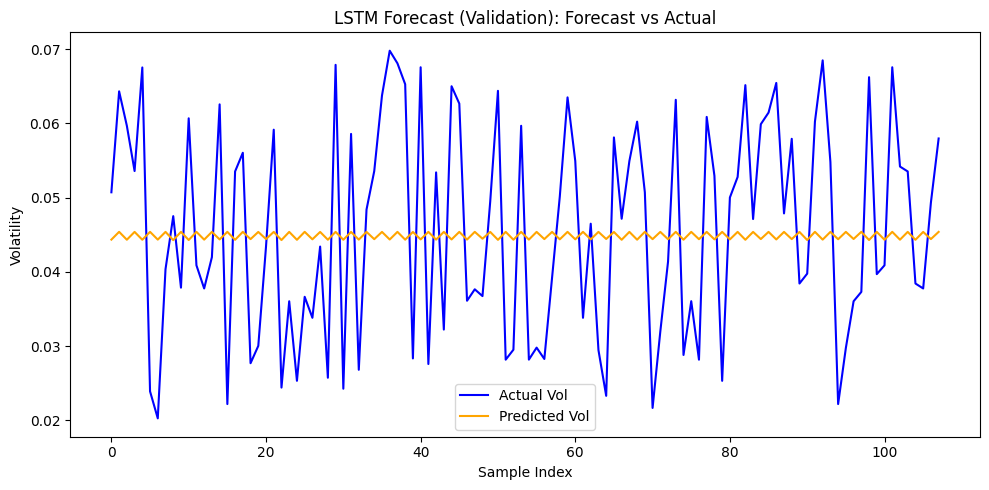

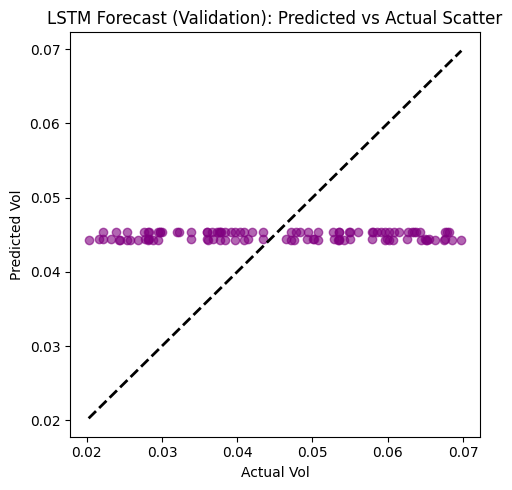

RMSE: 0.0145 | MAE: 0.0129 | Bias: -0.0009


In [3]:
# After training / predicting:
preds, actuals = lstm_f.predict()  # using your VolSenseForecaster wrapper
metrics = evaluate_forecasts(preds, actuals, title="LSTM Forecast (Validation)")

In [ ]:
from volsense_core.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
import pandas as pd
import numpy as np

# Pull actual OHLCV for SPY
df = fetch_ohlcv("SPY", start="2020-01-01")

# Compute realized vol (21-day) and daily returns
df = compute_returns_vol(df, window=21, ticker="SPY")  # adds 'vol_realized' and 'returns'
df["ticker"] = "SPY"  # ensure ticker column exists
df = df.rename(columns={"vol_realized": "realized_vol"})

# We'll use the daily returns column for GARCH
returns_series = df["return"].dropna()

print(df.head())

C:\Users\rahul\OneDrive\Documents\GitHub\VolSense\volsense_pkg\data_fetching\fetch_yf.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

         date    return  realized_vol ticker
21 2020-02-03  0.007429      0.120011    SPY
22 2020-02-04  0.015241      0.127837    SPY
23 2020-02-05  0.011548      0.132694    SPY
24 2020-02-06  0.003365      0.131964    SPY
25 2020-02-07 -0.005330      0.133394    SPY


Epoch 1/5 | Train Loss: 0.8799 | Val Loss: 0.2992
Epoch 2/5 | Train Loss: 0.4131 | Val Loss: 0.1374
Epoch 3/5 | Train Loss: 0.2058 | Val Loss: 0.0616
Epoch 4/5 | Train Loss: 0.1121 | Val Loss: 0.0388
Epoch 5/5 | Train Loss: 0.0736 | Val Loss: 0.0392
LSTM RMSE: 0.198023
GARCH RMSE: 0.829791


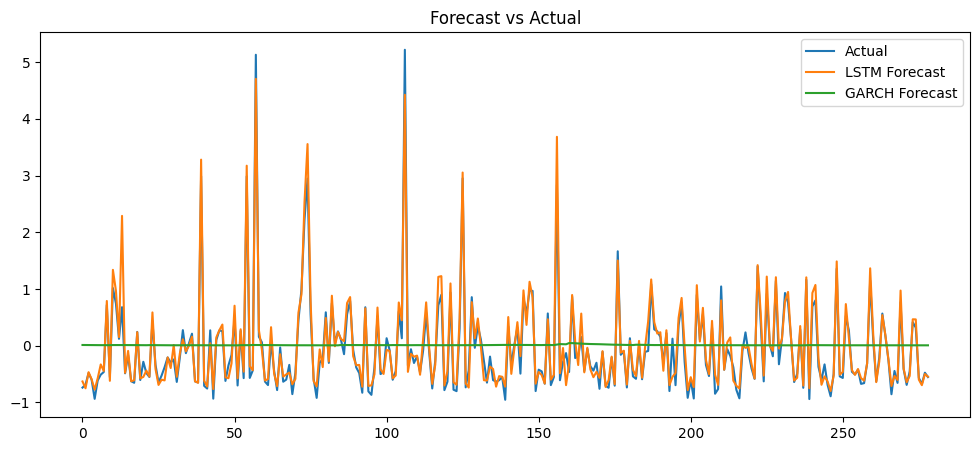

        date  realized_vol  lstm_pred_vol  garch_pred_vol
0 2025-07-30     -0.739408      -0.630800        0.012306
1 2024-06-05     -0.686629      -0.751072        0.011505
2 2023-07-21     -0.482489      -0.467333        0.010826
3 2025-07-02     -0.599587      -0.592861        0.010519
4 2025-06-16     -0.937458      -0.775465        0.010571


In [3]:
# === Fit LSTM forecaster (with built-in scaling) ===
lstm_f = VolSenseForecaster(method="lstm", window=30, horizon=1, hidden_dim=32)
lstm_f.fit(df, epochs=5, batch_size=32)

# === Fit GARCH forecaster on actual returns ===
garch_f = VolSenseForecaster(method="garch", p=1, q=1)
garch_f.fit(returns_series)

# === Evaluate & plot both LSTM + GARCH in one go ===
# VolSenseForecaster.evaluate_and_plot calls the underlying GARCHForecaster.predict()
# We’ll ask it for a rolling forecast time series:
y_pred_lstm, y_true, y_pred_garch = lstm_f.evaluate_and_plot(
    garch_forecaster=garch_f, garch_rolling=True
)

# === Build a quick DataFrame with results for further analysis ===
val_indices = lstm_f._val_loader.dataset.indices
val_dates = df.iloc[val_indices]["date"].reset_index(drop=True)

results_df = pd.DataFrame({
    "date": val_dates,
    "realized_vol": y_true,
    "lstm_pred_vol": y_pred_lstm,
    "garch_pred_vol": y_pred_garch
})

print(results_df.head())

C:\Users\rahul\OneDrive\Documents\GitHub\VolSense\volsense_pkg\data_fetching\fetch_yf.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Single ticker sample:


,date,return,vol_realized,ticker
21,2020-02-03,-0.002747,0.273964,AAPL
22,2020-02-04,0.033014,0.291458,AAPL
23,2020-02-05,0.008154,0.291495,AAPL
24,2020-02-06,0.011697,0.291225,AAPL
25,2020-02-07,-0.013593,0.294182,AAPL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Multi-ticker sample:


Price,date,return,realized_vol,ticker
Ticker,,,,
0,2020-02-03,-0.002747,0.273964,AAPL
1,2020-02-04,0.033014,0.291458,AAPL
2,2020-02-05,0.008154,0.291495,AAPL
3,2020-02-06,0.011697,0.291225,AAPL
4,2020-02-07,-0.013593,0.294182,AAPL


✅ Loaded cached data with 985 rows


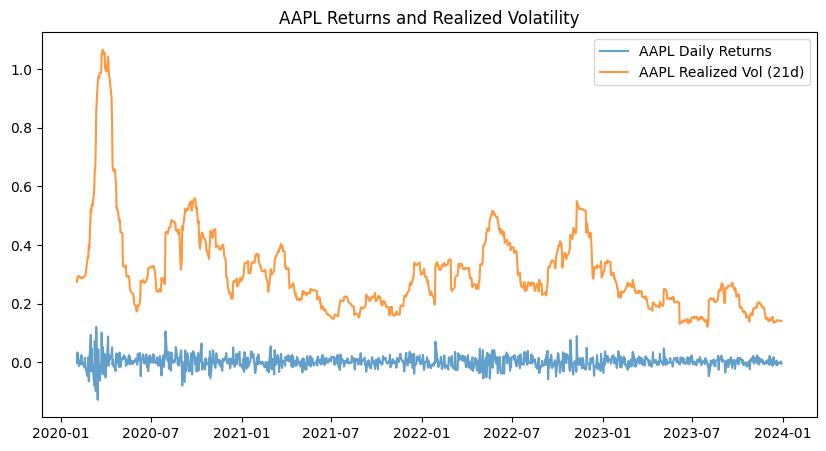

✅ Data layer test complete.


In [ ]:
# --- Test data layer utilities ---
from volsense_core.data_fetching.data_utils import (
    get_or_fetch_single,
    get_or_fetch_multi,
    load_from_cache,
)

# === Test single ticker (cached fetch) ===
df_single = get_or_fetch_single("AAPL", start="2020-01-01", end="2023-12-31", use_cache=True)
print("Single ticker sample:")
display(df_single.head())

# === Test multi-ticker ===
df_multi = get_or_fetch_multi(["AAPL", "MSFT"], start="2020-01-01", end="2023-12-31", lookback=21, use_cache=True)
print("Multi-ticker sample:")
display(df_multi.head())

# === Verify caching ===
try:
    df_cached = load_from_cache("AAPL_2020-01-01_2023-12-31")
    print(f"✅ Loaded cached data with {len(df_cached)} rows")
except FileNotFoundError:
    print("⚠️ Cache not found, first run likely just created it.")

# === Quick check plots ===
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_single["date"], df_single["return"], label="AAPL Daily Returns", alpha=0.7)
plt.plot(df_single["date"], df_single["vol_realized"], label="AAPL Realized Vol (21d)", alpha=0.8)
plt.legend()
plt.title("AAPL Returns and Realized Volatility")
plt.show()

print("✅ Data layer test complete.")

In [ ]:
from volsense_inference.pipeline.forecast_interface import forecast_interface, forecast_ticker, summarize_forecasts, forecast_multi_parallel

single_results = forecast_ticker(
    tickers=["SPY"], method="lstm",
    start="2020-01-01", lookback=15, horizon=1
)
print("\n=== Single Ticker (LSTM) ===")
print(summarize_forecasts(single_results))

parallel_results = forecast_multi_parallel(
    tickers=["SPY", "AAPL", "GOOG", "MSFT"],
    method="lstm",
    start="2020-01-01", lookback=15, horizon=1,
    max_workers=4
)
print("\n=== Multi Ticker (LSTM) Parallel ===")
print(summarize_forecasts(parallel_results))


📈 Processing SPY (LSTM)...
Epoch 1/5 | Train Loss: 0.8713 | Val Loss: 0.9723
Epoch 2/5 | Train Loss: 0.4704 | Val Loss: 0.4601
Epoch 3/5 | Train Loss: 0.2730 | Val Loss: 0.2504
Epoch 4/5 | Train Loss: 0.1520 | Val Loss: 0.1372
Epoch 5/5 | Train Loss: 0.1000 | Val Loss: 0.1025

=== Single Ticker (LSTM) ===
  ticker  realized_vol  forecast_vol  vol_diff  vol_direction
0    SPY      0.060138      0.217603  0.157465            1.0

🚀 Running parallel forecasts with 4 workers...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



📈 Processing SPY (LSTM)...

📈 Processing AAPL (LSTM)...

📈 Processing GOOG (LSTM)...

📈 Processing MSFT (LSTM)...
Epoch 1/5 | Train Loss: 0.8902 | Val Loss: 0.6043
Epoch 1/5 | Train Loss: 0.8038 | Val Loss: 0.6671
Epoch 1/5 | Train Loss: 0.8952 | Val Loss: 0.5146
Epoch 1/5 | Train Loss: 0.8875 | Val Loss: 0.2199
Epoch 2/5 | Train Loss: 0.4158 | Val Loss: 0.2820
Epoch 2/5 | Train Loss: 0.4147 | Val Loss: 0.4094
Epoch 2/5 | Train Loss: 0.4115 | Val Loss: 0.2856
Epoch 2/5 | Train Loss: 0.3500 | Val Loss: 0.1304
Epoch 3/5 | Train Loss: 0.2658 | Val Loss: 0.1659
Epoch 3/5 | Train Loss: 0.2603 | Val Loss: 0.2209
Epoch 3/5 | Train Loss: 0.2782 | Val Loss: 0.2154
Epoch 3/5 | Train Loss: 0.2238 | Val Loss: 0.0721
Epoch 4/5 | Train Loss: 0.1628 | Val Loss: 0.1085
Epoch 4/5 | Train Loss: 0.1563 | Val Loss: 0.1608
Epoch 4/5 | Train Loss: 0.1621 | Val Loss: 0.1631
Epoch 4/5 | Train Loss: 0.1258 | Val Loss: 0.0460
Epoch 5/5 | Train Loss: 0.1205 | Val Loss: 0.0935
Epoch 5/5 | Train Loss: 0.1386 | Va


🚀 Running multi-ticker LSTM backtest...

🚀 Running parallel forecasts with 4 workers...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



📈 Processing SPY (LSTM)...

📈 Processing AAPL (LSTM)...

📈 Processing GOOG (LSTM)...

📈 Processing MSFT (LSTM)...
Epoch 1/5 | Train Loss: 0.9071 | Val Loss: 0.9196
Epoch 1/5 | Train Loss: 0.9697 | Val Loss: 0.6551
Epoch 1/5 | Train Loss: 0.9886 | Val Loss: 0.7501
Epoch 1/5 | Train Loss: 0.8681 | Val Loss: 1.0590
Epoch 2/5 | Train Loss: 0.6138 | Val Loss: 0.5105
Epoch 2/5 | Train Loss: 0.6881 | Val Loss: 0.3811
Epoch 2/5 | Train Loss: 0.7290 | Val Loss: 0.4330
Epoch 2/5 | Train Loss: 0.6060 | Val Loss: 0.5592
Epoch 3/5 | Train Loss: 0.3932 | Val Loss: 0.3748
Epoch 3/5 | Train Loss: 0.4876 | Val Loss: 0.2894
Epoch 3/5 | Train Loss: 0.4579 | Val Loss: 0.3058
Epoch 3/5 | Train Loss: 0.3748 | Val Loss: 0.4322
Epoch 4/5 | Train Loss: 0.2873 | Val Loss: 0.2633
Epoch 4/5 | Train Loss: 0.3459 | Val Loss: 0.2132
Epoch 4/5 | Train Loss: 0.3129 | Val Loss: 0.2294
Epoch 4/5 | Train Loss: 0.2952 | Val Loss: 0.3119
Epoch 5/5 | Train Loss: 0.2022 | Val Loss: 0.1717
Epoch 5/5 | Train Loss: 0.2462 | Va

,ticker,realized_vol,forecast_vol,vol_diff,vol_direction
0,SPY,0.060138,-0.551562,-0.611701,-1.0
1,GOOG,0.222541,-0.047773,-0.270314,-1.0
2,AAPL,0.231423,1.854069,1.622646,1.0
3,MSFT,0.136533,1.149174,1.012641,1.0



=== Evaluation Metrics ===
  RMSE: 1.013123
   MAE: 0.879326
  MAPE: 645.366336
    R2: -209.468336


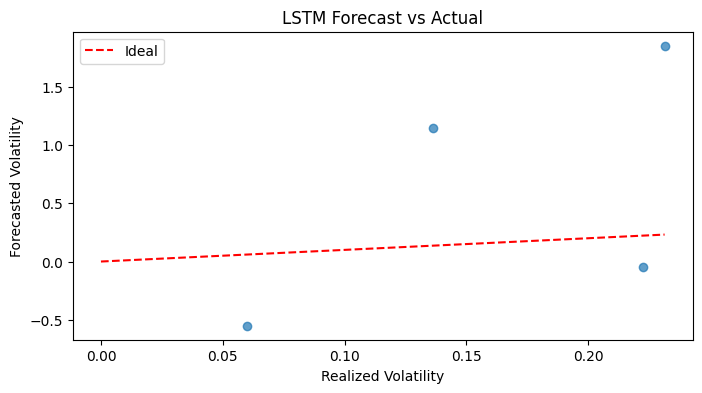

In [ ]:
# =====================================================
# 🌐 Phase 2: Backtesting & Evaluation Test
# =====================================================

from volsense_inference.pipeline.forecast_interface import (
    forecast_multi_parallel,
    forecast_single_ticker,
    summarize_forecasts
)
from volsense_core.utils.metrics import evaluate_forecasts

# --- Choose models and tickers ---
method = "lstm"
tickers = ["SPY", "AAPL", "GOOG", "MSFT"]

print(f"\n🚀 Running multi-ticker {method.upper()} backtest...")

# --- Run parallel forecasts ---
results = forecast_multi_parallel(
    tickers=tickers,
    method=method,
    start="2020-01-01",
    lookback=15,
    horizon=1,
    max_workers=4,
    p=1, q=1,
    hidden_dim=32, epochs=5, batch_size=32
)

# --- Summarize forecasts ---
summary_df = summarize_forecasts(results)
print("\n=== Forecast Summary ===")
display(summary_df)

# --- Evaluate model performance ---
if not summary_df.empty:
    metrics = evaluate_forecasts(summary_df)
    print("\n=== Evaluation Metrics ===")
    for k, v in metrics.items():
        print(f"{k:>6}: {v:.6f}")
else:
    print("\n⚠️ No forecasts to evaluate.")

# --- Optional visualization (quick check) ---
import matplotlib.pyplot as plt
if not summary_df.empty:
    plt.figure(figsize=(8, 4))
    plt.scatter(summary_df["realized_vol"], summary_df["forecast_vol"], alpha=0.7)
    plt.plot([0, max(summary_df["realized_vol"])], [0, max(summary_df["realized_vol"])], "r--", label="Ideal")
    plt.xlabel("Realized Volatility")
    plt.ylabel("Forecasted Volatility")
    plt.title(f"{method.upper()} Forecast vs Actual")
    plt.legend()
    plt.show()